In [2]:
%load_ext autoreload
%autoreload 2

# Data

In [4]:
from src.data import (
    fetch_transactions,
    save_btyd_features,
    save_customer_data,
)

In [5]:
transactions = fetch_transactions()
save_btyd_features(transactions)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Fetched 2828843 transactions from /Users/anthonybeech/python/dsci/ltv/data/transactions.parquet
Saved BTYD features to /Users/anthonybeech/python/dsci/ltv/data/btyd_features.parquet
No of customers: 1336231


In [6]:
save_customer_data()

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Saved 1336231 customer records to /Users/anthonybeech/python/dsci/ltv/data/customer_data.parquet


In [7]:
import pandas as pd
from src.config import BTYD_FEATURES_DATASET, CUSTOMER_DATA_DATASET

df = pd.read_parquet(BTYD_FEATURES_DATASET)
df_customer = pd.read_parquet(CUSTOMER_DATA_DATASET)

* Frequency: Number of distinct time units (e.g. days or weeks) in which the customer made a purchase — not the total number of purchases.
* T (Customer Age): Time between the customer’s first purchase and the end of the observation period.
* Recency: Time between the customer’s first and most recent purchase (0 if only one purchase).
* Monetary Value: Average purchase value = total spend / number of purchases (not based on frequency).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336231 entries, 0 to 1336230
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   customer_id      1336231 non-null  int32
 1   frequency        1336231 non-null  int32
 2   recency          1336231 non-null  int32
 3   T                1336231 non-null  int32
 4   monetary_value   1336231 non-null  int32
 5   days_since_last  1336231 non-null  int32
dtypes: int32(6)
memory usage: 30.6 MB


In [43]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).round(0)

,customer_id,frequency,recency,T,monetary_value,days_since_last,cohort_year
count,1336698.0,1336698.0,1336698.0,1336698.0,1336698.0,1336698.0,1336698.0
mean,2455168.0,1.0,235.0,1213.0,197.0,977.0,2022.0
std,1009320.0,5.0,565.0,980.0,518.0,903.0,3.0
min,812085.0,0.0,0.0,0.0,0.0,0.0,2000.0
25%,1555565.0,0.0,0.0,454.0,0.0,274.0,2020.0
50%,2447916.0,0.0,0.0,967.0,0.0,714.0,2023.0
75%,3279606.0,1.0,104.0,1724.0,191.0,1423.0,2024.0
90%,3890290.0,3.0,869.0,2604.0,626.0,2283.0,2025.0
99%,4295123.0,13.0,2751.0,4279.0,2216.0,4010.0,2025.0
max,4357276.0,1566.0,9347.0,9377.0,58806.0,9377.0,2025.0


array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'frequency'}>,
        <Axes: title={'center': 'recency'}>],
       [<Axes: title={'center': 'T'}>,
        <Axes: title={'center': 'monetary_value'}>,
        <Axes: title={'center': 'days_since_last'}>],
       [<Axes: title={'center': 'cohort_year'}>, <Axes: >, <Axes: >]],
      dtype=object)

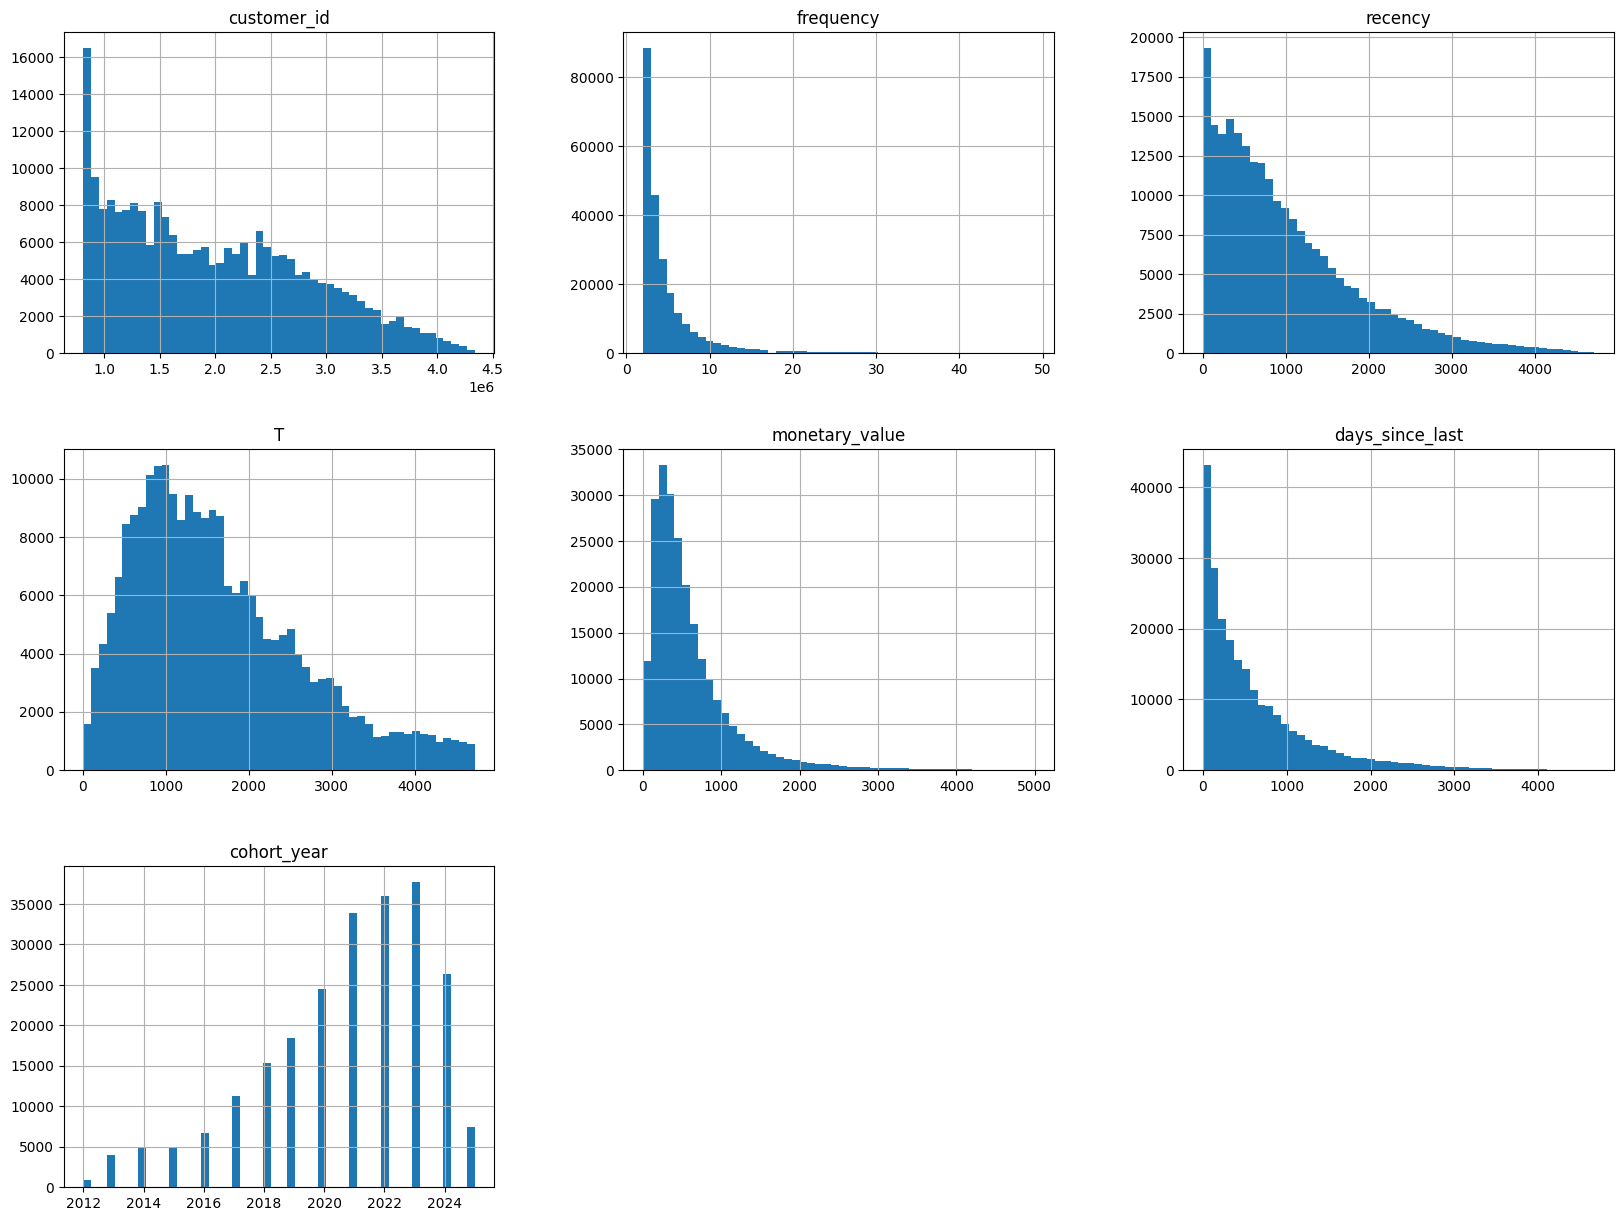

In [44]:
df[
    (df["frequency"] > 1)
    & (df["frequency"] < 50)
    & (df["recency"] < 5000)
    & (df["T"] < 5000)
    & (df["monetary_value"] < 5000)
].hist(bins=50, figsize=(20, 15))

In [11]:
df_customer.describe().round(0)

,customer_id,customer_three_year_gmv_lttv_gbp,customer_three_year_sell_value_lttv_gbp,buy_rfm_score,sell_rfm_score,days_to_second_transaction,is_active_customer,is_active_buyer,is_active_seller,is_habitual_customer,...,lenses_sold,cine_kit_sold,total_items_bought,avg_items_bought_per_txn,mirrorless_items_bought,dslr_items_bought,compact_items_bought,cameras_bought,lenses_bought,cine_kit_bought
count,1336231.0,479005.0,230846.0,1083494.0,491271.0,460549.0,1336231.0,1336231.0,1336231.0,1336231.0,...,491550.0,491550.0,1083796.0,1083796.0,1083796.0,1083796.0,1083796.0,1083796.0,1083796.0,1083796.0
mean,2454549.0,873.0,1268.0,20.0,24.0,303.0,0.0,0.0,0.0,0.0,...,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
std,1008919.0,4615.0,3074.0,12.0,17.0,469.0,0.0,0.0,0.0,0.0,...,6.0,1.0,34.0,0.0,5.0,29.0,1.0,9.0,24.0,0.0
min,812085.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1555312.0,158.0,204.0,12.0,14.0,17.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2447350.0,375.0,493.0,19.0,22.0,111.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,3278686.0,898.0,1260.0,25.0,28.0,385.0,1.0,0.0,0.0,0.0,...,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
max,4356401.0,2194133.0,329496.0,100.0,100.0,6674.0,1.0,1.0,1.0,1.0,...,931.0,439.0,24938.0,41.0,2335.0,23062.0,461.0,7342.0,17459.0,95.0


array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'customer_three_year_gmv_lttv_gbp'}>,
        <Axes: title={'center': 'customer_three_year_sell_value_lttv_gbp'}>,
        <Axes: title={'center': 'buy_rfm_score'}>,
        <Axes: title={'center': 'sell_rfm_score'}>,
        <Axes: title={'center': 'days_to_second_transaction'}>,
        <Axes: title={'center': 'is_active_customer'}>],
       [<Axes: title={'center': 'is_active_buyer'}>,
        <Axes: title={'center': 'is_active_seller'}>,
        <Axes: title={'center': 'is_habitual_customer'}>,
        <Axes: title={'center': 'is_habitual_buyer'}>,
        <Axes: title={'center': 'is_habitual_seller'}>,
        <Axes: title={'center': 'customer_all_time_gmv_gbp'}>,
        <Axes: title={'center': 'customer_all_time_sell_value_gbp'}>],
       [<Axes: title={'center': 'total_completed_transactions'}>,
        <Axes: title={'center': 'total_buy_transactions'}>,
        <Axes: title={'center': 'total_sell_

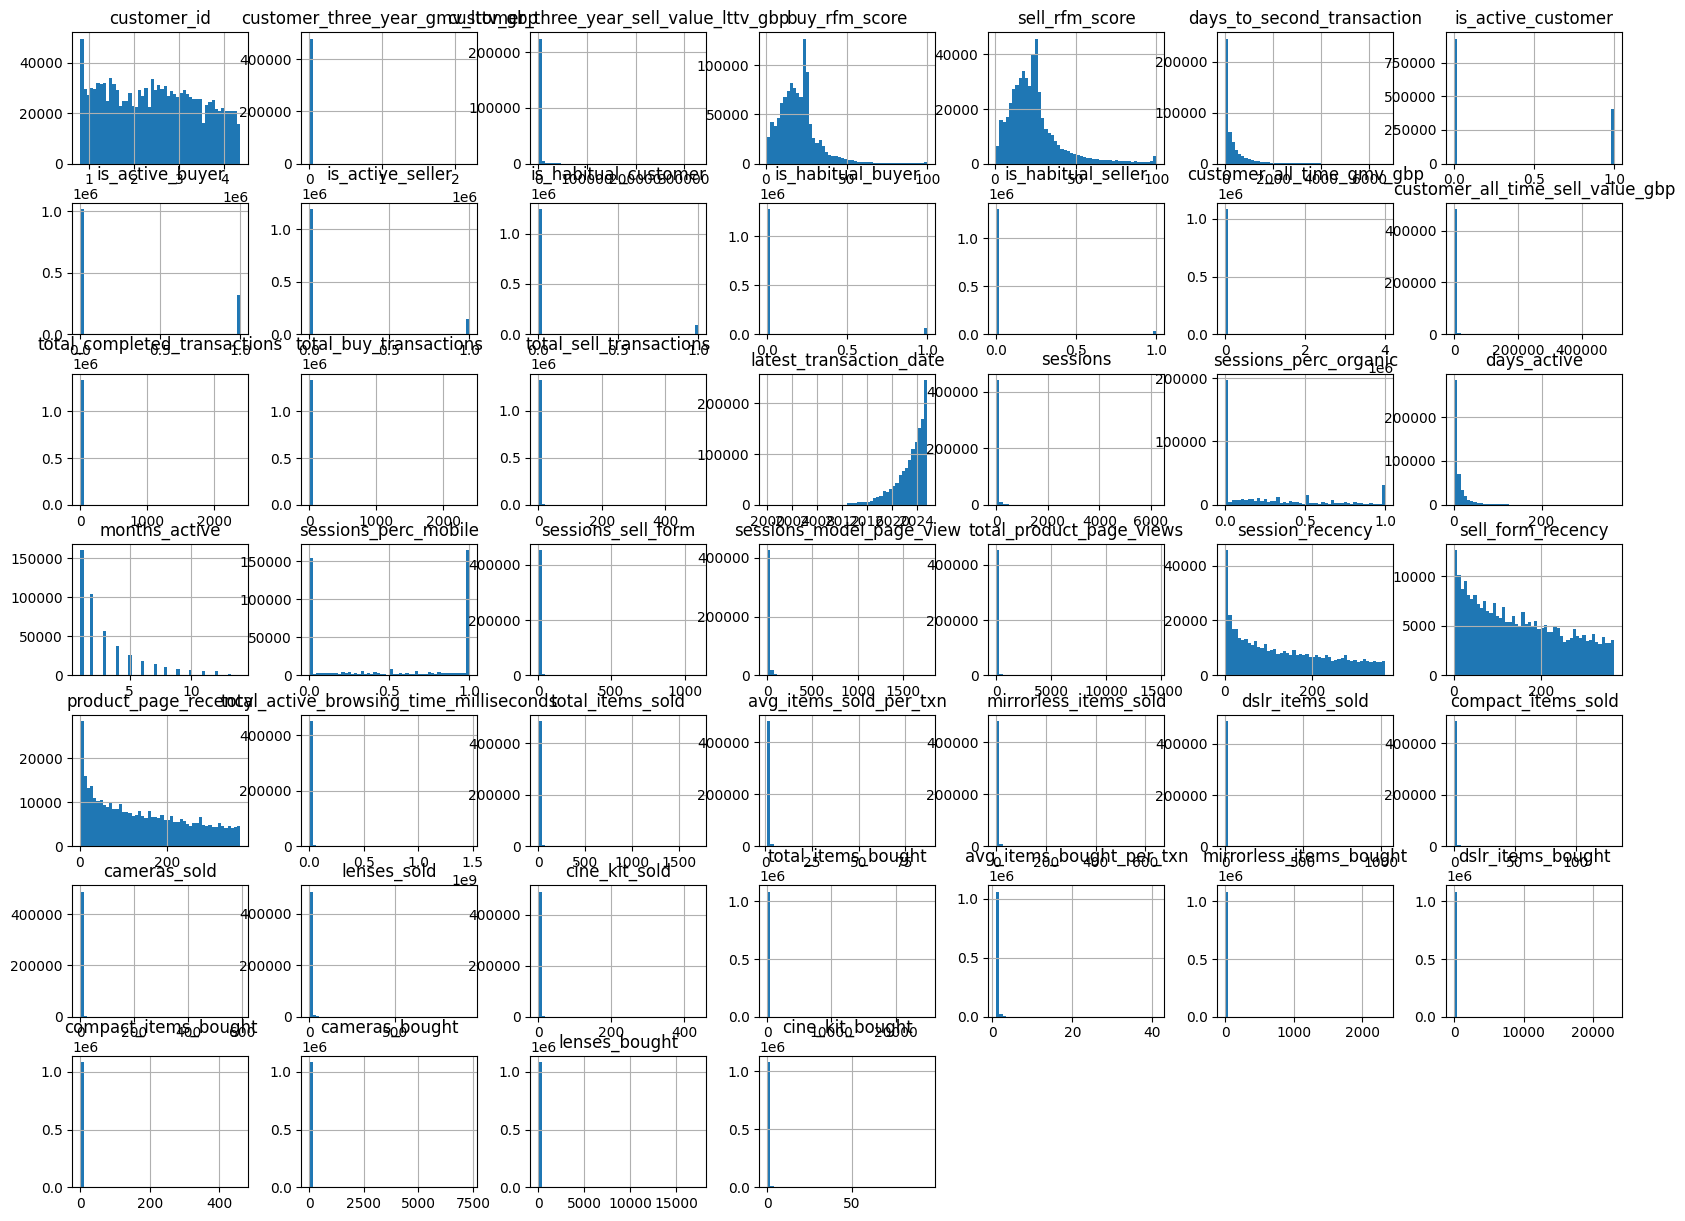

In [12]:
df_customer.hist(bins=50, figsize=(20, 15))

# Modelling

In [3]:
import pandas as pd
from src.config import BTYD_FEATURES_DATASET, CUSTOMER_DATA_DATASET
from src.data import save_btyd_features_with_survival

save_btyd_features_with_survival()


df = pd.read_parquet(BTYD_FEATURES_DATASET)
# df_customer = pd.read_parquet(CUSTOMER_DATA_DATASET)

Saved BTYD + survival features to /Users/anthonybeech/python/dsci/ltv/data/btyd_features.parquet
No of customers: 1336698


In [4]:
df = df[(df["frequency"] < 100) & (df["recency"] < 5000) & (df["T"] < 5000)].sample(
    n=10000, random_state=42
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 834267 to 807595
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   customer_id      10000 non-null  int32
 1   frequency        10000 non-null  int32
 2   recency          10000 non-null  int32
 3   T                10000 non-null  int32
 4   monetary_value   10000 non-null  int32
 5   days_since_last  10000 non-null  int32
 6   event_observed   10000 non-null  bool 
 7   cohort_year      10000 non-null  int32
 8   duration         10000 non-null  int32
dtypes: bool(1), int32(8)
memory usage: 400.4 KB


In [8]:
from src.model import (
    BaseModel,
    BGNBD,
    ParetoNBD,
    Empirical,
    BGNBDEmpiricalSingle,
    BGNBDEmpiricalSingleTrainNoSingle,
    ParetoEmpiricalSingleTrainNoSingle,
    CoxSurvivalModel,
    RandomSurvivalForestModel,
)

models: list[BaseModel] = [
    BGNBD(),
    ParetoNBD(),
    Empirical(),
    BGNBDEmpiricalSingle(),
    BGNBDEmpiricalSingleTrainNoSingle(),
    ParetoEmpiricalSingleTrainNoSingle(),
    CoxSurvivalModel(),
    RandomSurvivalForestModel(),
]

for model in models:
    print(f"Fitting {model.name}")
    model.fit(df)
    df[f"{model.name}_p_alive"] = model.p_alive(df)
    df[f"{model.name}_status"] = model.customer_status(df)
    df[f"{model.name}_future_transactions"] = model.predict_future_transactions(
        df, 365 * 5
    )

Fitting BGNBD
Fitting ParetoNBD
Fitting Empirical_270_540
Fitting BGNBDES_270_540
Fitting BGNBDESTNS_270_540
Fitting ParetoESTNS_270_540
Fitting CoxPH_90
Fitting RSF_90


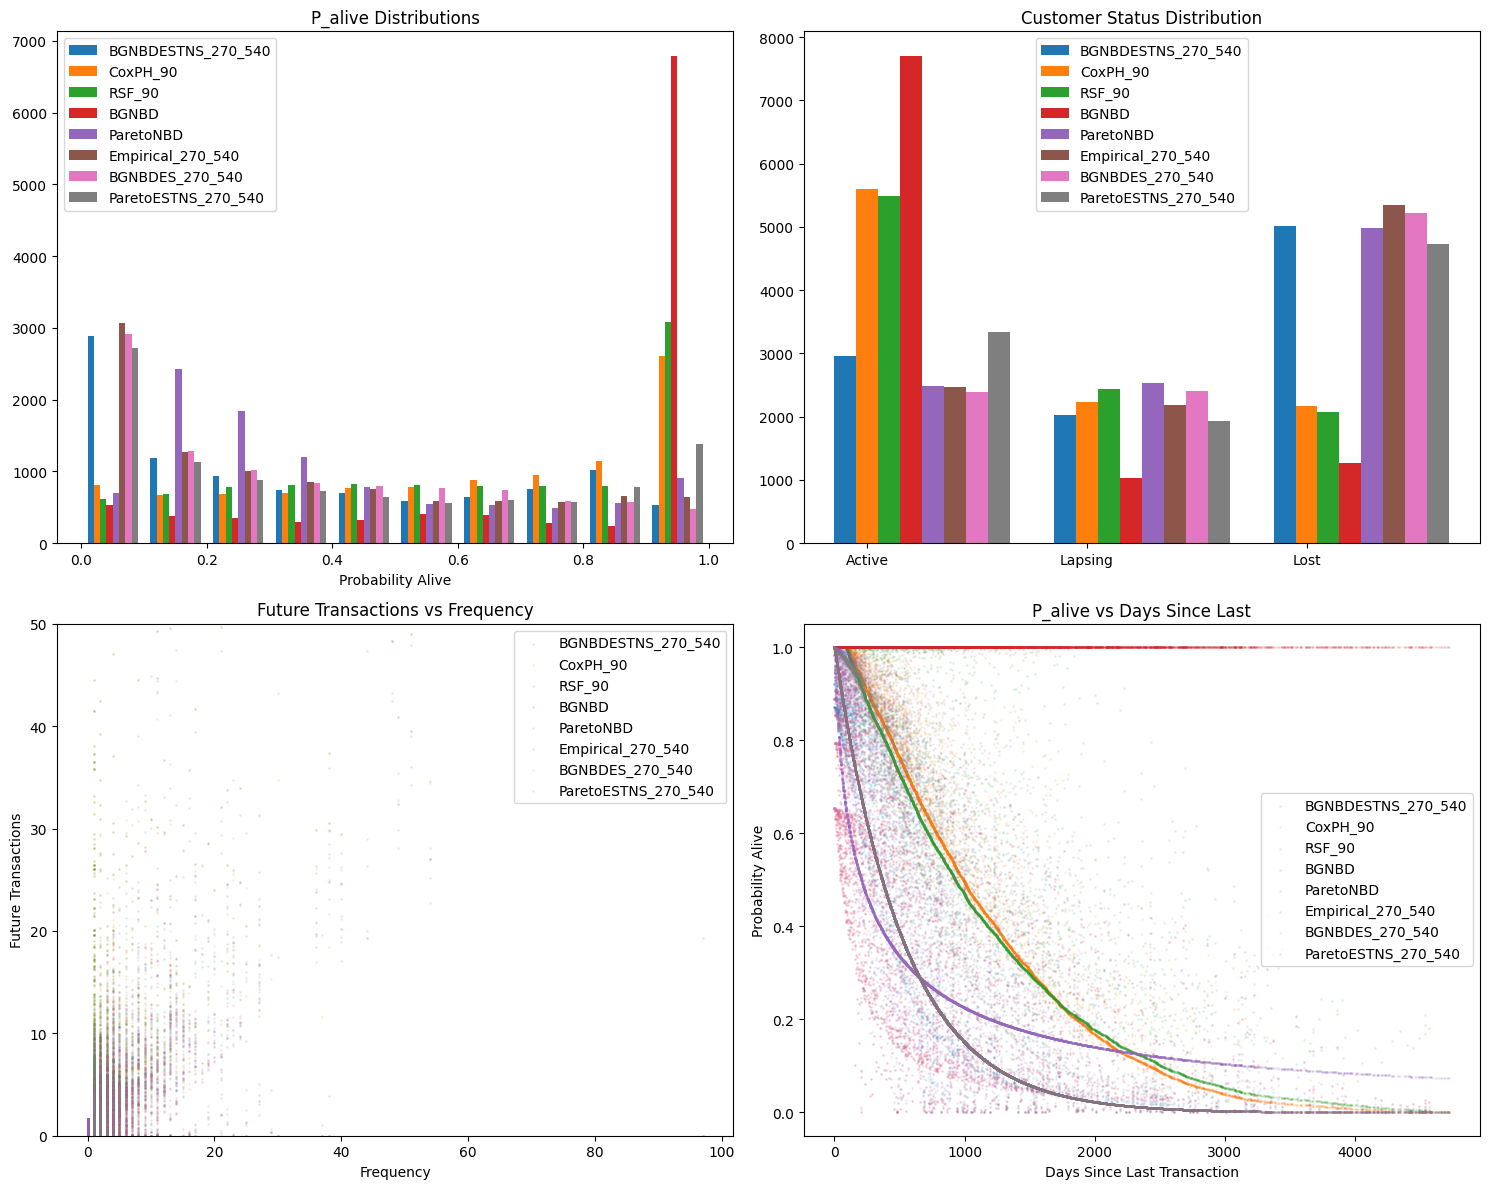

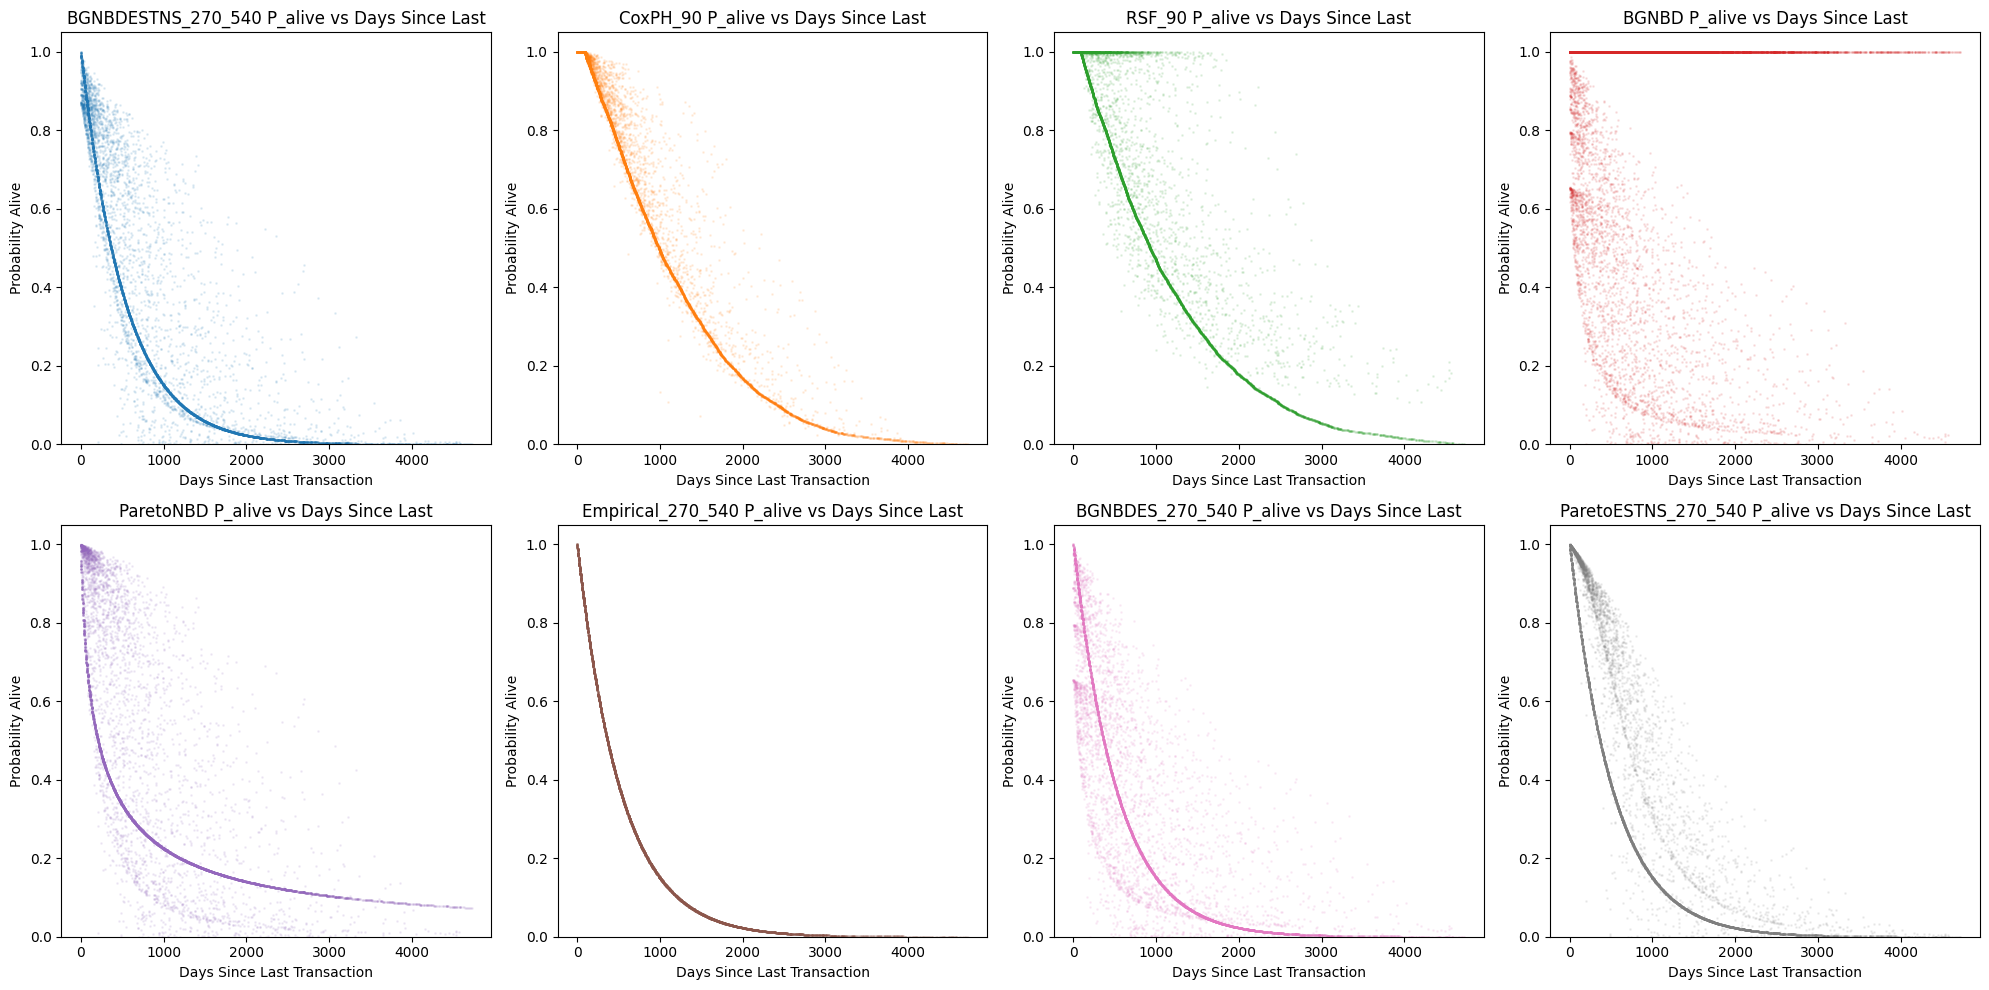

,Model,Avg P_alive,P_alive Std,Active %,Lapsing %,Lost %,Avg Future Txns
0,BGNBDESTNS_270_540,0.376753,0.316092,29.59,20.26,50.15,0.963810
1,CoxPH_90,0.613540,0.315886,55.93,22.40,21.67,1.845594
2,RSF_90,0.626563,0.319031,54.83,24.41,20.76,1.916395
3,BGNBD,0.809427,0.312765,77.07,10.32,12.61,0.934102
4,ParetoNBD,0.398561,0.281335,24.78,25.37,49.85,1.082792
5,Empirical_270_540,0.349000,0.307109,24.71,21.88,53.41,0.998205
6,BGNBDES_270_540,0.348043,0.294747,23.84,23.99,52.17,0.694008
7,ParetoESTNS_270_540,0.414364,0.342799,33.40,19.35,47.25,1.188766


In [9]:
from src.eval import evaluate_models

evaluate_models(df)

# Writing to BQ

In [ ]:
df.columns

Index(['customer_id', 'frequency', 'recency', 'T', 'monetary_value',
       'days_since_last', 'BGNBD_p_alive', 'BGNBD_status',
       'BGNBD_future_transactions', 'ParetoNBD_p_alive', 'ParetoNBD_status',
       'ParetoNBD_future_transactions', 'Empirical_270_540_p_alive',
       'Empirical_270_540_status', 'Empirical_270_540_future_transactions',
       'BGNBDES_270_540_p_alive', 'BGNBDES_270_540_status',
       'BGNBDES_270_540_future_transactions', 'BGNBDESTNS_270_540_p_alive',
       'BGNBDESTNS_270_540_status', 'BGNBDESTNS_270_540_future_transactions',
       'ParetoESTNS_270_540_p_alive', 'ParetoESTNS_270_540_status',
       'ParetoESTNS_270_540_future_transactions', 'Weibull_270_540_p_alive',
       'Weibull_270_540_status', 'Weibull_270_540_future_transactions'],
      dtype='object')

In [ ]:
# Join df_customer with df_model_predictions
df_combined = df_customer.merge(df, on="customer_id", how="left")

In [19]:
from src.utils.bq import BQ

bq = BQ()

bq.to_bq(df_combined, "mpb-data-science-dev-ab-602d.sandbox.customer_ltv_analysis")

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


BadRequest: 400 POST https://bigquery.googleapis.com/upload/bigquery/v2/projects/mpb-data-science-dev-ab-602d/jobs?uploadType=resumable: Provided Schema does not match Table mpb-data-science-dev-ab-602d:sandbox.customer_ltv_analysis. Cannot add fields (field: Weibull_270_540_p_alive)